In [1]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

class CallGraphBuilder(ast.NodeVisitor):
    """
    Builds a simple call graph:
    - Nodes: function names
    - Edges: caller -> callee for direct calls like foo()
    Limitations: won't fully resolve dynamic calls, methods, imports, etc.
    """
    def __init__(self):
        self.graph = nx.DiGraph()
        self.current_func = None

    def visit_FunctionDef(self, node: ast.FunctionDef):
        func_name = node.name
        self.graph.add_node(func_name)

        prev = self.current_func
        self.current_func = func_name

        self.generic_visit(node)  # visit body

        self.current_func = prev

    def visit_Call(self, node: ast.Call):
        if self.current_func is None:
            # Calls at top-level (outside any function) are ignored (or you can model them)
            self.generic_visit(node)
            return

        callee = self._get_callee_name(node.func)
        if callee is not None:
            self.graph.add_node(callee)
            self.graph.add_edge(self.current_func, callee)

        self.generic_visit(node)

    def _get_callee_name(self, func_node):
        # Handles:
        #   foo()            -> "foo"
        #   obj.method()     -> "obj.method" (string form; not resolved to class)
        if isinstance(func_node, ast.Name):
            return func_node.id
        if isinstance(func_node, ast.Attribute):
            base = self._get_attr_base(func_node.value)
            return f"{base}.{func_node.attr}" if base else func_node.attr
        return None

    def _get_attr_base(self, node):
        if isinstance(node, ast.Name):
            return node.id
        if isinstance(node, ast.Attribute):
            base = self._get_attr_base(node.value)
            return f"{base}.{node.attr}" if base else node.attr
        return None


def build_call_graph_from_source(source_code: str) -> nx.DiGraph:
    tree = ast.parse(source_code)
    builder = CallGraphBuilder()
    builder.visit(tree)
    return builder.graph


def draw_call_graph(G: nx.DiGraph, title="Call Graph"):
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000)
    plt.title(title)
    plt.show()


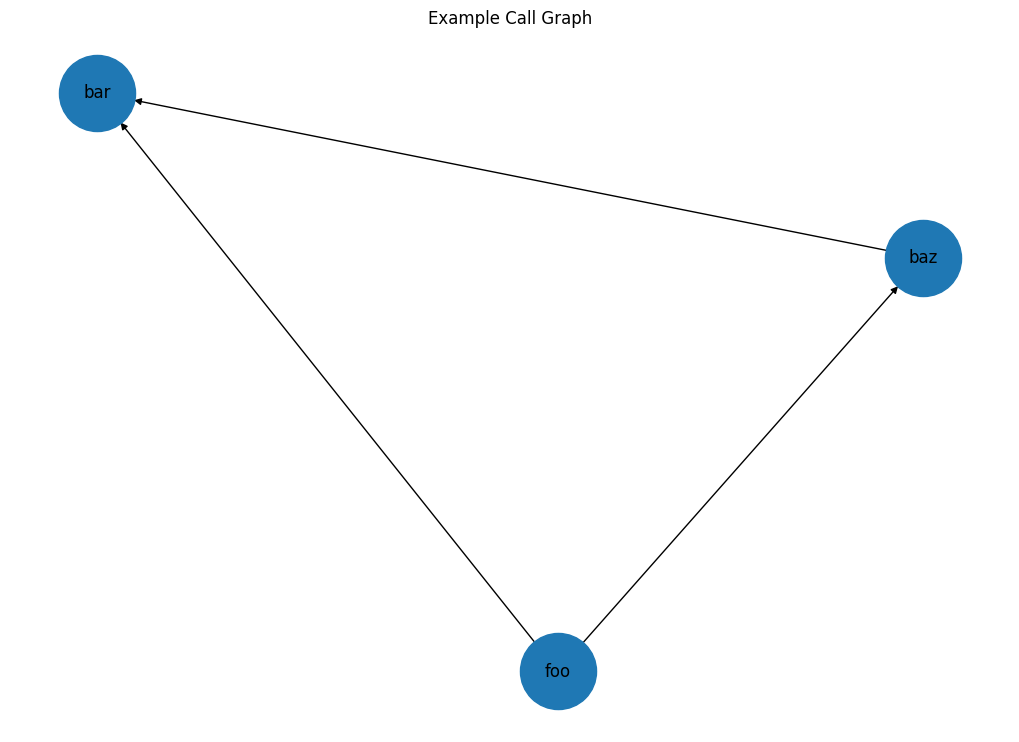

Edges: [('baz', 'bar'), ('foo', 'bar'), ('foo', 'baz')]


In [2]:
code = """
def bar():
    pass

def baz():
    bar()

def foo():
    bar()
    baz()

foo()
"""

G = build_call_graph_from_source(code)
draw_call_graph(G, "Example Call Graph")
print("Edges:", list(G.edges()))


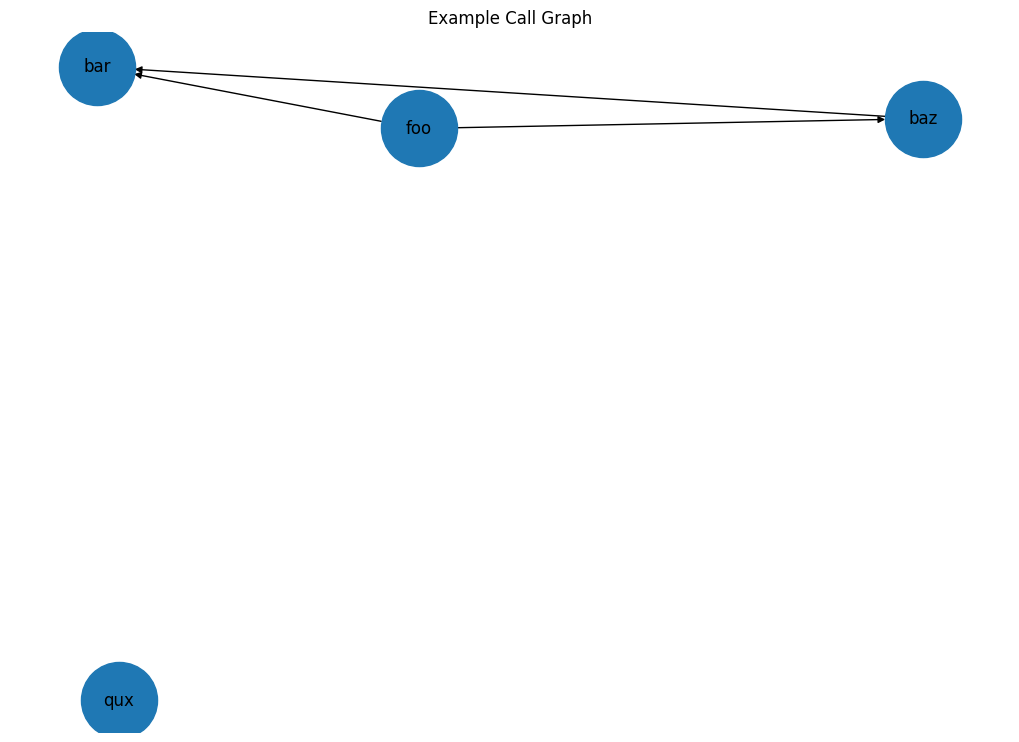

Edges: [('baz', 'bar'), ('foo', 'bar'), ('foo', 'baz')]


In [3]:
code = """
def bar():
    pass

def baz():
    bar()

def qux():
    pass

def foo():
    bar()
    baz()

    

foo()
"""

G = build_call_graph_from_source(code)
draw_call_graph(G, "Example Call Graph")
print("Edges:", list(G.edges()))


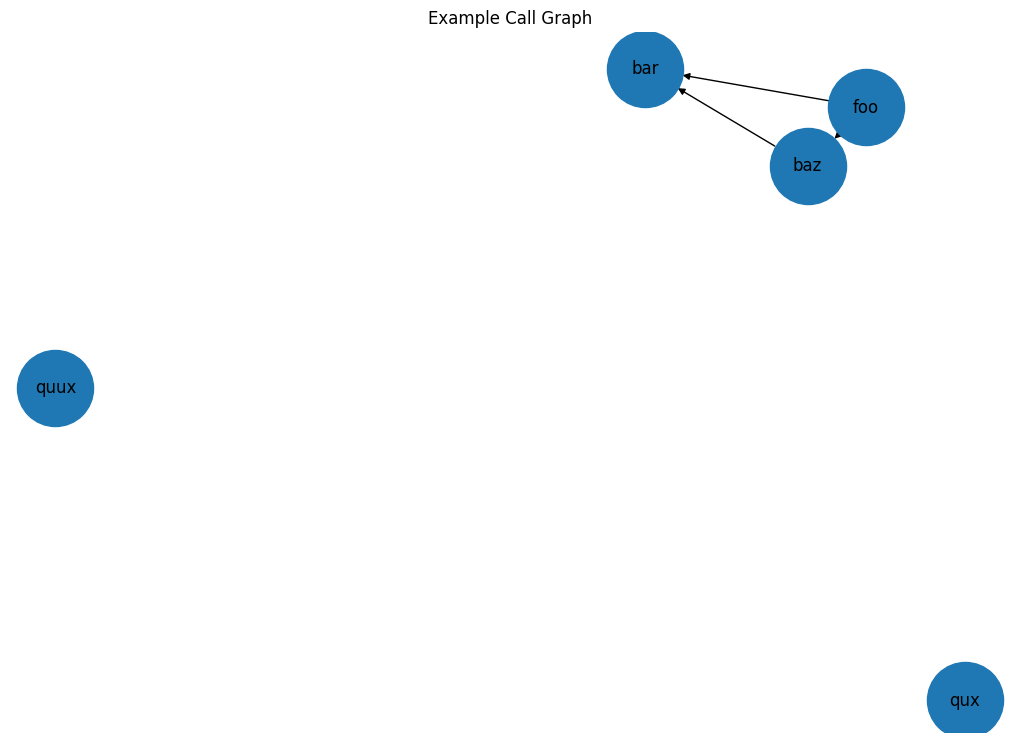

Edges: [('baz', 'bar'), ('foo', 'bar'), ('foo', 'baz')]


In [4]:
code = """
def bar():
    pass

def baz():
    bar()

def qux():
    pass

def quux():
    pass    

def foo():
    bar()
    baz()

    

foo()
"""

G = build_call_graph_from_source(code)
draw_call_graph(G, "Example Call Graph")
print("Edges:", list(G.edges()))


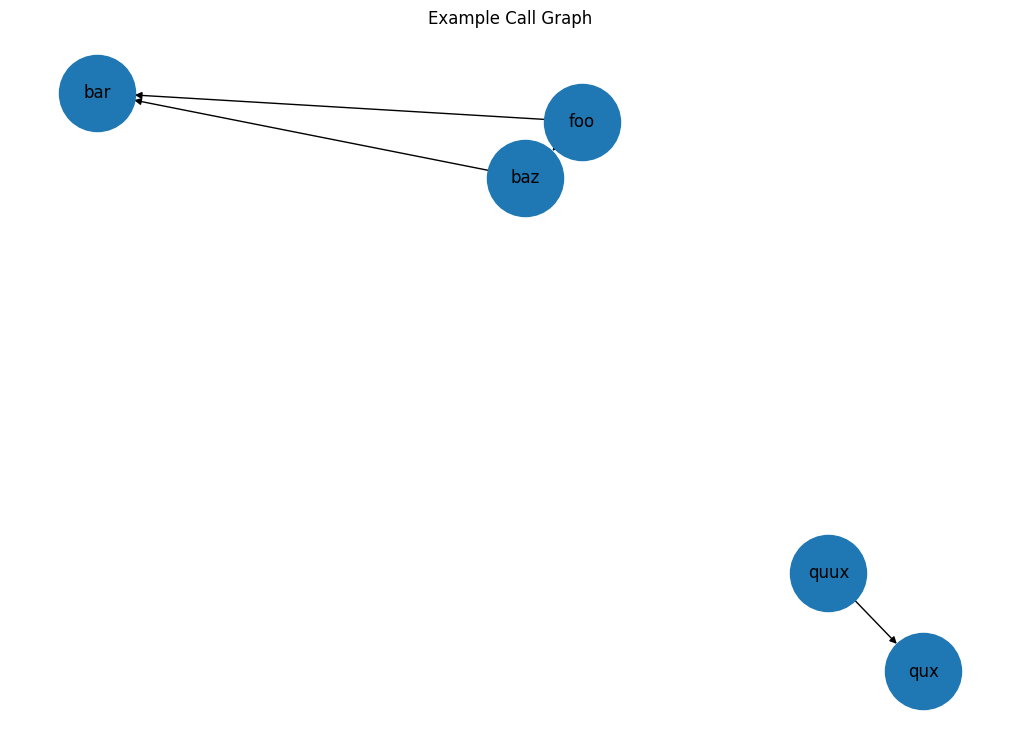

Edges: [('baz', 'bar'), ('quux', 'qux'), ('foo', 'bar'), ('foo', 'baz')]


In [5]:
code = """
def bar():
    pass

def baz():
    bar()

def qux():
    pass

def quux():
    qux()    

def foo():
    bar()
    baz()

    

foo()
"""

G = build_call_graph_from_source(code)
draw_call_graph(G, "Example Call Graph")
print("Edges:", list(G.edges()))
